In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import os
import random

In [2]:
import os
import sys
from PIL import Image
import tensorflow as tf

#### Data Prepration

In [3]:
data_dir = path.expanduser('.\data')
train_data_dir = path.join(data_dir, 'train')
test_data_dir = path.join(data_dir, 'test')
val_data_dir = path.join(data_dir, 'val')

In [4]:
class_names = os.listdir(train_data_dir)
class_names = class_names[1:]
class_namesId = {label: index-1 for index, label in enumerate(class_names) if label != '.DS_Store'}

In [5]:
class_namesId
class_names

['NORMAL', 'PNEUMONIA']

In [6]:
import pickle
with open(os.path.join(data_dir, 'class_namesId.p'), 'wb') as p:
    pickle.dump(class_namesId, p, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
def create_data(dirs, classes, ids, i):
    folder = path.join(dirs, classes[i])
    x = os.listdir(folder)
    filenames = [(path.join(folder,m)) for m in x[1:]]
    m = [i]*len(filenames)
    df1 = pd.DataFrame({'Image': filenames, 'PNEUMONIA': m})
    return df1

In [8]:
df1 = create_data(train_data_dir, class_names, class_namesId, 0)
df2 = create_data(train_data_dir, class_names, class_namesId, 1)
train_data = pd.concat([df1, df2]).reset_index(drop=True)

In [9]:
df1 = create_data(test_data_dir, class_names, class_namesId, 0)
df2 = create_data(test_data_dir, class_names, class_namesId, 1)
test_data = pd.concat([df1, df2]).reset_index(drop=True)

In [10]:
df1 = create_data(val_data_dir, class_names, class_namesId, 0)
df2 = create_data(val_data_dir, class_names, class_namesId, 1)
val_data = pd.concat([df1, df2]).reset_index(drop=True)

In [11]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

In [12]:
import matplotlib.image as img
normal = img.imread('.\\data\\train\\NORMAL\\IM-0117-0001.jpeg')
pneumonia = img.imread('.\\data\\train\\PNEUMONIA\\person986_bacteria_2913.jpeg')

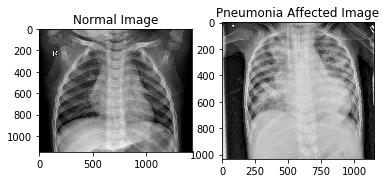

In [13]:
plt.subplot(1, 2, 1)
plt.imshow(normal, cmap=plt.get_cmap('gray'))
plt.title('Normal Image')
plt.subplot(1, 2, 2)
plt.imshow(pneumonia, cmap=plt.get_cmap('gray'))
plt.title('Pneumonia Affected Image')
plt.show()

In [14]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator( rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

Using TensorFlow backend.


In [15]:
def load_image(imagePath, size):
    return img_to_array(load_img(imagePath, color_mode='grayscale', target_size=(size, size))) / 255.

In [16]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras

In [17]:
class ImageSequence(keras.utils.Sequence):
    def __init__(self, df, im_size, batch_size, mode='train'):
        self.df = df
        self.im_size = im_size
        self.batch_size = batch_size
        self.mode = mode
        self.imagePathList = self.df['Image'].tolist()
        if self.mode == 'train':
            self.classLabelList = self.df['PNEUMONIA'].tolist()
            self.label_encoder = LabelEncoder()
            self.onehot_encoder = OneHotEncoder(sparse=False)
            self.integer_encoded = self.label_encoder.fit_transform(self.classLabelList)
            self.integer_encoded = self.integer_encoded.reshape(len(self.integer_encoded), 1)
            self.classLabelEnc = self.onehot_encoder.fit_transform(self.integer_encoded)
        
    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))
    
    def on_epoch_end(self):
        self.indexes = range(len(self.imagePathList))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))
            
    def get_batch_labels(self, idx): 
        # Fetch a batch of labels
        return self.classLabelEnc[idx * self.batch_size: (idx + 1) * self.batch_size]

    def get_batch_features(self, idx):
        # Fetch a batch of images
        batch_images = self.imagePathList[idx * self.batch_size: (1 + idx) * self.batch_size]
        return np.array([load_image(im, self.im_size) for im in batch_images])

    def __getitem__(self, idx):
        if self.mode == 'train':
            batch_x = self.get_batch_features(idx)
            batch_y = self.get_batch_labels(idx)
            return batch_x, batch_y
        else:
            batch_x = self.get_batch_features(idx)
            return batch_x

In [18]:
obj = ImageSequence(train_data, im_size = 64, batch_size=50)
valObj = ImageSequence(val_data, im_size = 64, batch_size=12)

C:\Users\SPECTRE\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\SPECTRE\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case yo

#### CNN Model 

In [19]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('./model.h1', verbose=1, save_best_only=True, mode=min)]

In [20]:
inp = keras.layers.Input(shape=(64, 64, 1))
conv1 = keras.layers.Conv2D(64, 5, 1, activation=tf.nn.relu, use_bias=True)(inp)
conv2 = keras.layers.Conv2D(64,5, 1, activation=tf.nn.relu, use_bias=True)(conv1)
max1 = keras.layers.MaxPool2D(pool_size = (2,2),strides= 2, padding= "same")(conv2)
norm1 = keras.layers.BatchNormalization()(max1)
conv3 = keras.layers.Conv2D(64,3, 1, activation=tf.nn.relu, use_bias=True)(norm1)
conv4 = keras.layers.Conv2D(64,3, 1, activation=tf.nn.relu, use_bias=True)(conv3)
max2 = keras.layers.MaxPool2D(pool_size = (2,2),strides= 2, padding= "same")(conv4)
norm2 = keras.layers.BatchNormalization()(max2)
conv5 = keras.layers.Conv2D(128,3, 1, activation=tf.nn.selu, use_bias=True)(norm2)
conv6 = keras.layers.Conv2D(128,3, 1, activation=tf.nn.selu, use_bias=True)(conv5)
avg1 = keras.layers.AvgPool2D(pool_size = (2,2),strides= 2, padding= "same")(conv6)
flat = keras.layers.Flatten()(avg1)
fc1 = keras.layers.Dense(1024, activation=tf.nn.relu)(flat)
fc1 = keras.layers.Dropout(0.2)(fc1)
fc2 = keras.layers.Dense(512, activation=tf.nn.relu)(fc1)
fc2 = keras.layers.Dropout(0.2)(fc2)
fc3 = keras.layers.Dense(128, activation=tf.nn.relu)(fc2)
fc3 = keras.layers.Dropout(0.2)(fc3)

classLabel = keras.layers.Dense(2, activation=tf.nn.softmax, name='class')(fc3)
model1 = keras.Model(inputs = inp, outputs=classLabel)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
__________

In [22]:
model1.compile(optimizer='sgd', loss = {'class':"binary_crossentropy"}, metrics=['accuracy'])

In [24]:
model1.fit_generator(
    generator = obj, 
    validation_data = valObj,
    shuffle = True,
    steps_per_epoch = 82, 
    epochs = 10,
    verbose = 1,
)

Epoch 1/10
105/105 [==============================] - 278s 3s/step - loss: 0.4483 - acc: 0.8133 - val_loss: 0.6486 - val_acc: 0.5000
Epoch 2/10
105/105 [==============================] - 296s 3s/step - loss: 0.1824 - acc: 0.9285 - val_loss: 0.9094 - val_acc: 0.5000
Epoch 3/10
105/105 [==============================] - 301s 3s/step - loss: 0.0913 - acc: 0.9668 - val_loss: 0.8770 - val_acc: 0.5625
Epoch 4/10
105/105 [==============================] - 301s 3s/step - loss: 0.0517 - acc: 0.9818 - val_loss: 1.2311 - val_acc: 0.5625
Epoch 5/10
105/105 [==============================] - 300s 3s/step - loss: 0.0226 - acc: 0.9927 - val_loss: 1.7894 - val_acc: 0.5625
Epoch 6/10
105/105 [==============================] - 301s 3s/step - loss: 0.0159 - acc: 0.9954 - val_loss: 1.7868 - val_acc: 0.5625
Epoch 7/10
105/105 [==============================] - 305s 3s/step - loss: 0.0179 - acc: 0.9944 - val_loss: 0.5873 - val_acc: 0.6875
Epoch 8/10
105/105 [==============================] - 303s 3s/step - 

In [25]:
testObj = ImageSequence(test_data, im_size = 64, batch_size=32)

C:\Users\SPECTRE\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [26]:
def prediction_f(model, test_data, testObj):
    predictions = model.predict_generator(generator=testObj, verbose=1)
    labels = np.argmax(predictions, axis=-1) 
    test_pred = labels.T
    X = test_data['PNEUMONIA']==test_pred
    acc = (np.sum(X)/len(test_data))*100
    #tN = tf.keras.metrics.TrueNegatives(test_data['PNEUMONIA'], test_data['Predictions'])
    return predictions, X, acc
    

In [27]:
probas1, pred1, accuracy1_50 = prediction_f(model1, test_data, testObj)

20/20 [==============================] - 10s 475ms/step


In [28]:
accuracy1_50

63.18327974276527

In [ ]:
X = pd.DataFrame({'prob':probas1[:,1], 'true': pred1})

In [ ]:
X.head()

In [29]:
inp = keras.layers.Input(shape=(64, 64, 1))
conv1 = keras.layers.Conv2D(64, 11, 1, activation=tf.nn.relu, use_bias=True)(inp)
conv2 = keras.layers.Conv2D(64, 7, 1, activation=tf.nn.relu, use_bias=True)(conv1)
max1 = keras.layers.MaxPool2D(pool_size = (2,2),strides= 2, padding= "same")(conv2)
norm1 = keras.layers.BatchNormalization()(max1)
conv3 = keras.layers.Conv2D(128, 3, 1, activation=tf.nn.relu, use_bias=True)(norm1)
conv4 = keras.layers.Conv2D(128, 3, 1, activation=tf.nn.relu, use_bias=True)(conv3)
max2 = keras.layers.MaxPool2D(pool_size = (3,3),strides= 2, padding= "same")(conv4)
norm2 = keras.layers.BatchNormalization()(max2)
conv5 = keras.layers.Conv2D(128, 3, 1, activation=tf.nn.selu, use_bias=True)(norm2)
conv6 = keras.layers.Conv2D(128, 3, 1, activation=tf.nn.selu, use_bias=True)(conv5)
avg1 = keras.layers.AvgPool2D(pool_size = (3,3),strides= 2, padding= "same")(conv6)
flat = keras.layers.Flatten()(avg1)
fc1 = keras.layers.Dense(1024, activation=tf.nn.relu)(flat)
fc1 = keras.layers.Dropout(0.2)(fc1)
fc2 = keras.layers.Dense(512, activation=tf.nn.relu)(fc1)
fc2 = keras.layers.Dropout(0.2)(fc2)
fc3 = keras.layers.Dense(128, activation=tf.nn.relu)(fc2)
fc3 = keras.layers.Dropout(0.2)(fc3)

classLabel = keras.layers.Dense(2, activation=tf.nn.softmax, name='class')(fc3)
model2 = keras.Model(inputs = inp, outputs=classLabel)

In [30]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 54, 64)        7808      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        200768    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 128)       147584    
__________

In [31]:
model2.compile(optimizer='sgd', loss = {'class':"binary_crossentropy"}, metrics=['accuracy'])

In [32]:
model1.fit_generator(
    generator = obj, 
    validation_data = valObj,
    shuffle = True,
    steps_per_epoch = 82, 
    epochs = 10,
    verbose = 1,
)

Epoch 1/10
105/105 [==============================] - 274s 3s/step - loss: 0.0119 - acc: 0.9977 - val_loss: 0.5894 - val_acc: 0.6250
Epoch 2/10
105/105 [==============================] - 296s 3s/step - loss: 0.0071 - acc: 0.9983 - val_loss: 0.8375 - val_acc: 0.6250
Epoch 3/10
105/105 [==============================] - 300s 3s/step - loss: 0.0048 - acc: 0.9985 - val_loss: 1.9643 - val_acc: 0.5625
Epoch 4/10
105/105 [==============================] - 301s 3s/step - loss: 0.0052 - acc: 0.9981 - val_loss: 0.8394 - val_acc: 0.5625
Epoch 5/10
105/105 [==============================] - 300s 3s/step - loss: 0.0032 - acc: 0.9990 - val_loss: 2.0186 - val_acc: 0.5000
Epoch 6/10
105/105 [==============================] - 301s 3s/step - loss: 0.0061 - acc: 0.9979 - val_loss: 0.5953 - val_acc: 0.5625
Epoch 7/10
105/105 [==============================] - 321s 3s/step - loss: 0.0040 - acc: 0.9990 - val_loss: 0.8792 - val_acc: 0.6250
Epoch 8/10
105/105 [==============================] - 318s 3s/step - 

In [33]:
probas2, pred2, accuracy2_50 = prediction_f(model1, test_data, testObj)

20/20 [==============================] - 12s 606ms/step


In [34]:
accuracy2_50

71.86495176848875